In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.special import expit
from scipy import io
import sys

In [2]:
wine_data = io.loadmat("data/{}.mat".format("wine")) 
print("\nloaded data!") 
fields = "y", "X", "X_test" 
for field in fields:
    print(field, wine_data[field].shape)


loaded data!
y (6000, 1)
X (6000, 12)
X_test (497, 12)


In [3]:
#N,d = wine_data["X"].shape
#wine_data["X"] = np.concatenate((wine_data["X"], np.ones((N,1))), axis=1)
np.random.seed(69)
X_train_raw = wine_data["X"]
y_train_raw = wine_data["y"]

full_set = np.concatenate((X_train_raw, y_train_raw), axis=1)
np.random.shuffle(full_set)

X_train_raw = full_set[:4000, :-1]
y_train = full_set[:4000, -1:].reshape(-1,)

X_val_raw = full_set[4000:, :-1]
y_val = full_set[4000:, -1:].reshape(-1,)

In [4]:
mean_features = None
std_features = None

def sigmoid(X, w):
    return expit(np.matmul(X, w.T))

def normalize(X, mean=None, std=None):
    N,d = X.shape
    
    if not mean:
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        mean_features = mean
        std_features = std
        
    X = (X - mean) / std
    
    X = np.concatenate((X, np.ones((N,1))), axis=1)
    return X
        
def batch_logistic_loss(X, y, w, reg):
    reg_term = (reg / 2) * w.T.dot(w)

    loss_0 = np.dot(y.T, np.log(sigmoid(X, w)))
    loss_1 = np.dot((1 - y).T, np.log(1-sigmoid(X,w)))
    
    return reg_term - loss_0 - loss_1

def batch_compute_update(X, y, w, reg, eps):
    sig = sigmoid(X,w)
    gradient = np.matmul(X.T, (y-sig))
    grad_step = reg*w - gradient
    
    return w - (eps * grad_step)

from save_csv import results_to_csv
def predict_and_save(X, w):
    out_y = sigmoid(X, w)
    pred_y = (out_y > 0.5).astype(np.int32)
    pred_y = pred_y.reshape(-1,)
    results_to_csv(pred_y)

# Batch Gradient Descent

In [253]:
_lambda = 1
epsilon = 1e-5
X_train = normalize(X_train_raw)

def train_batch_step(X, y, w, reg, eps):
    loss = batch_logistic_loss(X, y, w, reg)
    next_w = batch_compute_update(X, y, w, reg, eps)
    return loss, next_w

def train(num_iterations, X_train, y_train, w_train, regularization_param, epsilon, verbose):
    training_loss_history = []
    for curr_iter in range(num_iterations):
        loss, next_w = train_batch_step(X_train, y_train, w_train, regularization_param, epsilon)

        training_loss_history.append(float(loss))
        w_train = next_w
        if verbose and (curr_iter) % verbose == 0:
            print("Iter {}: loss = {}".format(curr_iter+1, training_loss_history[-1]))
        
    
    return w_train, training_loss_history

## Training with full 6000 examples
print("---- Training with all 6000 examples ---")
w_train = np.ones(13)
verbose = 500
num_iterations = 10000
batch_best_w, batch_tl = train(num_iterations, X_train, y_train, w_train, _lambda, epsilon, verbose)

---- Training with all 6000 examples ---
Iter 1: loss = 5589.095850056396
Iter 501: loss = 406.15827313604507
Iter 1001: loss = 275.27091247323915
Iter 1501: loss = 232.5169797145283
Iter 2001: loss = 212.34911891171183
Iter 2501: loss = 200.89553229509863
Iter 3001: loss = 193.51783152664194
Iter 3501: loss = 188.3265222225553
Iter 4001: loss = 184.43738272377146
Iter 4501: loss = 181.3880989535129
Iter 5001: loss = 178.91444002322856
Iter 5501: loss = 176.8542507702304
Iter 6001: loss = 175.10220014016548
Iter 6501: loss = 173.5866774259469
Iter 7001: loss = 172.25716704920237
Iter 7501: loss = 171.0769396241473
Iter 8001: loss = 170.0186085636202
Iter 8501: loss = 169.06131439912775
Iter 9001: loss = 168.1888765731196
Iter 9501: loss = 167.3885432385773


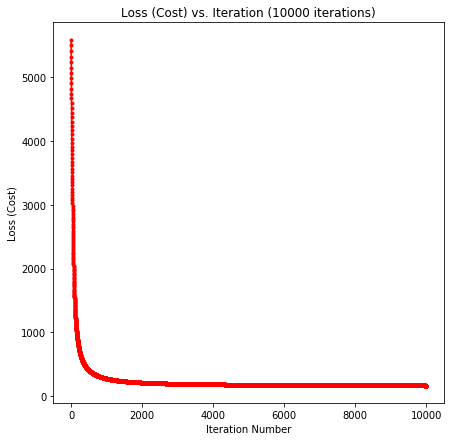

In [254]:
iterations = list(np.arange(1, num_iterations+1, 1))
fig, ax2 = plt.subplots(1, 1, figsize=(7, 7)) 

ax2.plot(iterations, batch_tl, '.r-') 
ax2.set_title("Loss (Cost) vs. Iteration (10000 iterations)") 
ax2.set_xlabel("Iteration Number")
ax2.set_ylabel("Loss (Cost)")
plt.show()

### Training Accuracy

In [255]:
out_y = sigmoid(X_train, batch_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
(y_train == pred_y).astype(np.int32).mean()
# pred_y.sum()
# y_train.sum()

0.9935

### Validation Accuracy

In [256]:
X_val = normalize(X_val_raw, mean_features, std_features)
out_y = sigmoid(X_val, batch_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
(y_val == pred_y).astype(np.int32).mean()
# pred_y.sum()
# y_val.sum()

0.9935

#### Saving best LR prediction using Batch GD

In [258]:
X_test_raw = wine_data["X_test"]
X_test = normalize(X_test_raw, mean_features, std_features)

out_y = sigmoid(X_test, batch_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
print(pred_y.sum())


results_to_csv(pred_y)

130


## Stochastic Gradient Descent

In [5]:
# x_i is of shape (1, d)
# y_i is of shape (1,1)

def sigmoid_single(x_i, w):
    return 1 / (1 + np.exp(-np.dot(x_i, w)))

def sgd_compute_update(x_i, y_i, w, reg, eps):
    sig = sigmoid_single(x_i.T,w)
    gradient = np.dot(x_i, (y_i-sig))
    grad_step = reg*w - gradient
    
    return w - (eps * grad_step)

In [260]:
regularization_param = 1
epsilon = 1e-4
X_train = normalize(X_train_raw)
def train_sgd(num_iterations, X_train, y_train, w_train, regularization_param, epsilon, verbose):
    training_loss_history = []
    N, d = X_train.shape
    for curr_iter in range(num_iterations):
        X_sample = X_train[curr_iter % N]
        y_sample = y_train[curr_iter % N]
        
        loss = batch_logistic_loss(X_train, y_train, w_train, regularization_param)
        w_train = sgd_compute_update(X_sample, y_sample, w_train, regularization_param, epsilon)
        
        training_loss_history.append(float(loss))

        if verbose and (curr_iter ) % verbose == 0:
            print("Iter {}: loss = {}".format(curr_iter+1, training_loss_history[-1]))
    
    return w_train, training_loss_history

## Training with full 6000 examples
print("---- Training with all 6000 examples ---")
w_train = np.ones(13)
verbose = 2000
num_iterations = 40000
sgd_best_w, sgd_tl = train_sgd(num_iterations, X_train, y_train, w_train, regularization_param, epsilon, verbose)

---- Training with all 6000 examples ---
Iter 1: loss = 5589.095850056396
Iter 2001: loss = 4445.675016442289
Iter 4001: loss = 3591.1865397983865
Iter 6001: loss = 2977.6488578063613
Iter 8001: loss = 2549.328457750065
Iter 10001: loss = 2262.730168961833
Iter 12001: loss = 2075.122526562736
Iter 14001: loss = 1958.1671228701407
Iter 16001: loss = 1884.318495159488
Iter 18001: loss = 1841.4960149377828
Iter 20001: loss = 1814.256020813375
Iter 22001: loss = 1800.1146371836678
Iter 24001: loss = 1790.3157500582686
Iter 26001: loss = 1786.3991776422633
Iter 28001: loss = 1782.7513465460943
Iter 30001: loss = 1782.2082437803265
Iter 32001: loss = 1780.6140395197617
Iter 34001: loss = 1781.0680071776133
Iter 36001: loss = 1780.117520831224
Iter 38001: loss = 1780.8067744462985


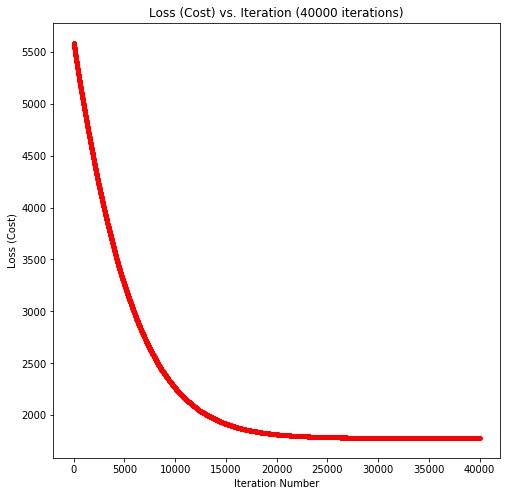

In [261]:
iterations = list(np.arange(1, num_iterations+1, 1))
fig, ax2 = plt.subplots(1, 1, figsize=(8, 8)) 

ax2.plot(iterations, sgd_tl, '.r-') 
ax2.set_title("Loss (Cost) vs. Iteration (40000 iterations)") 
ax2.set_xlabel("Iteration Number")
ax2.set_ylabel("Loss (Cost)")
plt.show()

### Accuracy on training set

In [262]:
out_y = sigmoid(X_train, sgd_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
(y_train == pred_y).astype(np.int32).mean()

0.974

### Accuracy on Validation Set

In [263]:
X_val = normalize(X_val_raw, mean_features, std_features)
out_y = sigmoid(X_val, sgd_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
(y_val == pred_y).astype(np.int32).mean()

0.9685

### Testing sum of testing predictions

In [264]:
X_test_raw = wine_data["X_test"]
X_test = normalize(X_test_raw, mean_features, std_features)

out_y = sigmoid(X_test, sgd_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
print(pred_y.sum())

140


# SGD With Decaying Learning Rate

In [6]:
regularization_param = 1
delta = .25
X_train = normalize(X_train_raw)

def train_sgd_decay(num_iterations, X_train, y_train, w_train, regularization_param, delta, verbose):
    training_loss_history = []
    N, d = X_train.shape
    for curr_iter in range(num_iterations):
        
        epsilon = delta / (curr_iter + 1)
        
        X_sample = X_train[curr_iter % N]
        y_sample = y_train[curr_iter % N]
        
        loss = batch_logistic_loss(X_train, y_train, w_train, regularization_param)
        w_train = sgd_compute_update(X_sample, y_sample, w_train, regularization_param, epsilon)
        
        training_loss_history.append(float(loss))

        if verbose and (curr_iter ) % verbose == 0:
            print("Iter {}: loss = {}".format(curr_iter+1, training_loss_history[-1]))
#             print("{}; Iter {}: loss = {}".format(epsilon, curr_iter+1, training_loss_history[-1]))
    
    return w_train, training_loss_history
        
# Training with different iteration counts
print("---- Training with all 6000 examples ---")
w_train = np.ones(13)
verbose = 2000
num_iterations = 40000
sgd_decay_best_w, sgd_decay_tl = train_sgd_decay(num_iterations, X_train, y_train, w_train, regularization_param, delta, verbose)

---- Training with all 6000 examples ---
Iter 1: loss = 5589.095850056396
Iter 2001: loss = 1792.6726392406686
Iter 4001: loss = 1783.726696437725
Iter 6001: loss = 1781.6282207499544
Iter 8001: loss = 1779.7710841303615
Iter 10001: loss = 1779.2703510952115
Iter 12001: loss = 1778.448505340246
Iter 14001: loss = 1778.2909486788462
Iter 16001: loss = 1777.8207385597195
Iter 18001: loss = 1777.780519579104
Iter 20001: loss = 1777.4732377424834
Iter 22001: loss = 1777.482189200657
Iter 24001: loss = 1777.2642417944808
Iter 26001: loss = 1777.295971358733
Iter 28001: loss = 1777.1325294756439
Iter 30001: loss = 1777.175201546631
Iter 32001: loss = 1777.0475759174396
Iter 34001: loss = 1777.0953576159047
Iter 36001: loss = 1776.9925894470807
Iter 38001: loss = 1777.0424225195416


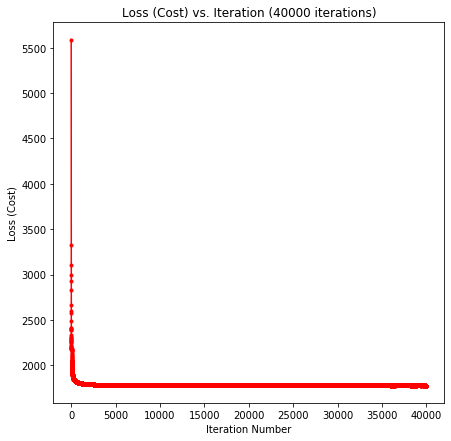

In [7]:
iterations = list(np.arange(1, num_iterations+1, 1))
fig, ax2 = plt.subplots(1, 1, figsize=(7, 7)) 

ax2.plot(iterations, sgd_decay_tl, '.r-') 
ax2.set_title("Loss (Cost) vs. Iteration (40000 iterations)") 
ax2.set_xlabel("Iteration Number")
ax2.set_ylabel("Loss (Cost)")
plt.show()

### Accuracy on training set

In [8]:
out_y = sigmoid(X_train, sgd_decay_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
(y_train == pred_y).astype(np.int32).mean()

0.9715

### Accuracy on Validation Set

In [9]:
X_val = normalize(X_val_raw, mean_features, std_features)
out_y = sigmoid(X_val, sgd_decay_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
(y_val == pred_y).astype(np.int32).mean()

0.9635

### Testing sum of testing predictions

In [10]:
X_test_raw = wine_data["X_test"]
X_test = normalize(X_test_raw, mean_features, std_features)

out_y = sigmoid(X_test, sgd_decay_best_w)
pred_y = (out_y > 0.5).astype(np.int32)
pred_y = pred_y.reshape(-1,)
print(pred_y.sum())

139
